In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm, model_selection
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import seaborn as sns
import category_encoders as ce

In [2]:
data = pd.read_csv("laptops.csv", index_col=0)

In [3]:
data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


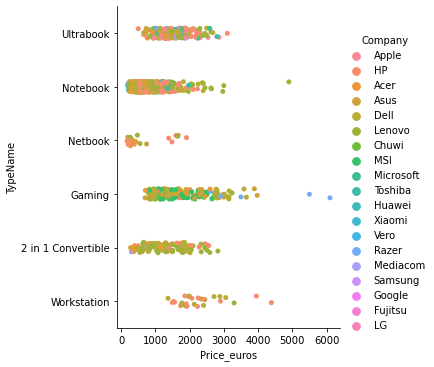

In [5]:
sns.catplot(x = "Price_euros",y = 'TypeName',data = data, hue = "Company")

<AxesSubplot:xlabel='Price_euros', ylabel='Company'>

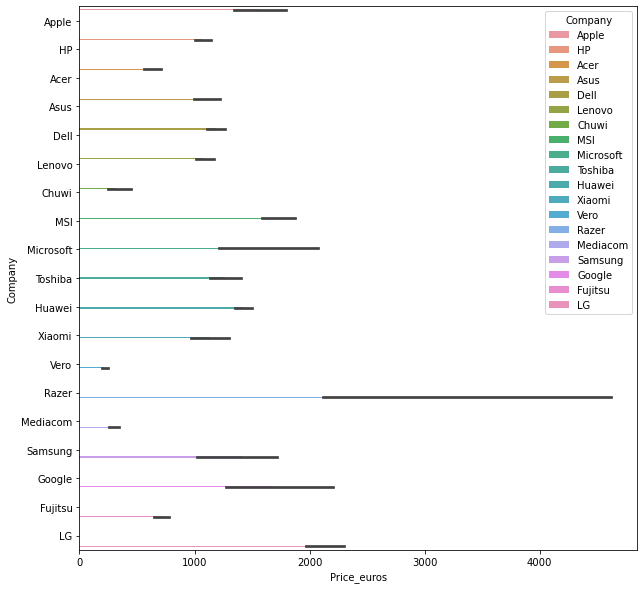

In [6]:
plt.subplots(figsize=(10,10))
sns.barplot(x = "Price_euros",y = 'Company',data = data, hue = "Company")

<AxesSubplot:xlabel='TypeName', ylabel='Price_euros'>

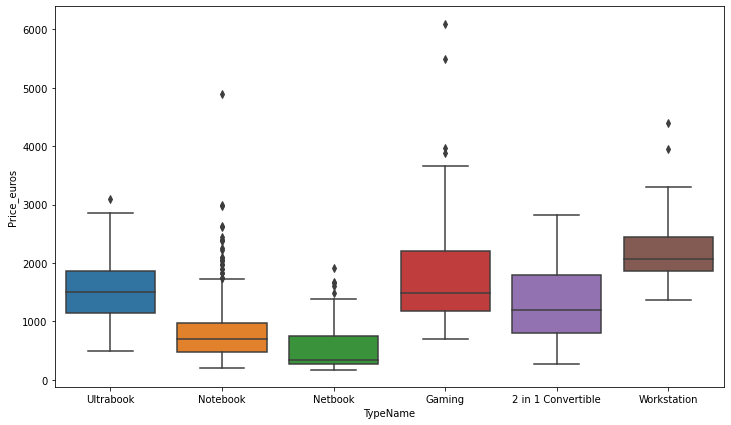

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='TypeName',y='Price_euros',data = data)

## dealing with outliers using iqr score


In [8]:
Q1 = data['Price_euros'].quantile(0.25)
Q3 = data['Price_euros'].quantile(0.75)
IQR = Q3 - Q1
filter = (data['Price_euros'] >= Q1 - 1.5 * IQR) & (data['Price_euros'] <= Q3 + 1.5 *IQR)
data = data.loc[filter]

<AxesSubplot:xlabel='TypeName', ylabel='Price_euros'>

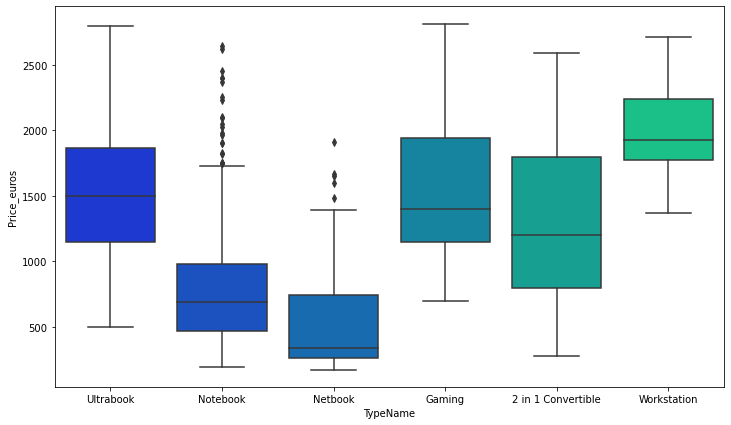

In [9]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='TypeName',y='Price_euros',data = data,palette='winter')

## data cleaning

In [10]:
#Function to handlesuffixes
def sufrem(clmn):
    clmn = clmn.str.replace(r'TB', '')
    clmn = clmn.str.replace(r'GB', '').fillna(0)
    return clmn
def TBhandle(clmn):
    if clmn < 6 :
        return clmn*1024
    else :
        return clmn

In [11]:
def clean(df):
    df['Ram'] = df['Ram'].replace('[GB]', '', regex=True)   #converting int values from obj to int and removing suffixes
    df['Ram'] = pd.to_numeric(df['Ram'])
    df['Weight'] = df['Weight'].replace('[kg]', '', regex=True)
    df['Weight'] = pd.to_numeric(df['Weight'])
    df['cpu_speed(GHz)'] = pd.to_numeric(df['Cpu'].str.split(' ').str[-1].replace('[GHz]', '', regex=True))
    df['cpu_manuf'] = df['Cpu'].str.split(' ').str[0]
    df['Horizontal'] = pd.to_numeric(df['ScreenResolution'].str.split(' ').str[-1].str.split('x').str[0])
    df['Vertical'] = pd.to_numeric(df['ScreenResolution'].str.split(' ').str[-1].str.split('x').str[1])
    t_arr = []
    for i in df['ScreenResolution'] :                      #new column touch 
        s = i.split(' ')
        if "Touchscreen" in s:
            touch = True
        else :
            touch = False
        t_arr.append(touch)
    df['Touch'] = pd.to_numeric(t_arr)
    SSD = []
    HDD = []
    Hybrid = []
    Flash = []
    for i in df['Memory']:                                  #split memory to ssd hdd flash and hybrid and convert to int
        dual_s = i.split(' ')
        if "SSD" in dual_s :
            SSD_val = dual_s[dual_s.index('SSD')-1]
            SSD.append(SSD_val)
        else :
            SSD.append('0')
        if "HDD" in dual_s :
            HDD_val = dual_s[dual_s.index("HDD")-1]
            HDD.append(HDD_val)
        else :
            HDD.append('0')
        if "Flash" in dual_s :
            Flash_val = dual_s[dual_s.index("Flash")-1]
            Flash.append(Flash_val)
        else :
            Flash.append('0')
        if "Hybrid" in dual_s :
            Hybrid_val = dual_s[dual_s.index("Hybrid")-1]
            Hybrid.append(Hybrid_val)
        else :
            Hybrid.append('0')
    df['Flash'] = Flash
    df['HDD'] = HDD
    df['SSD'] = SSD
    df['Hybrid'] = Hybrid
    df[['HDD','SSD','Flash','Hybrid']] = df[['HDD','SSD','Flash','Hybrid']].apply(sufrem)
    df['HDD'] = pd.to_numeric(df['HDD']).apply(TBhandle)
    df['SSD'] = pd.to_numeric(df['SSD']).apply(TBhandle)
    df['Flash'] = pd.to_numeric(df['Flash']).apply(TBhandle)
    df['Hybrid'] = pd.to_numeric(df['Hybrid']).apply(TBhandle)
    #encoding categorical values using pd.get_dummies
    cpu_dummies = pd.get_dummies(df['cpu_manuf'], prefix = 'cpu')
    opsys_dummies = pd.get_dummies(df['OpSys'], prefix = 'op')
    type_dummies = pd.get_dummies(df['TypeName'], prefix = 'Type')
    df = pd.concat([cpu_dummies, type_dummies , opsys_dummies, df], axis=1)
    df.drop('cpu_manuf',axis = 1, inplace = True)
    df.drop('OpSys',axis = 1, inplace = True)
    df.drop('TypeName',axis = 1, inplace = True)
    df.drop(columns=['Memory','Company','Product','ScreenResolution','Cpu'], inplace = True)
    return df

df = clean(data)

<ipython-input-11-ae30cbf87ce1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ram'] = df['Ram'].replace('[GB]', '', regex=True)   #converting int values from obj to int and removing suffixes
<ipython-input-11-ae30cbf87ce1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ram'] = pd.to_numeric(df['Ram'])
<ipython-input-11-ae30cbf87ce1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

<AxesSubplot:xlabel='Ram', ylabel='Price_euros'>

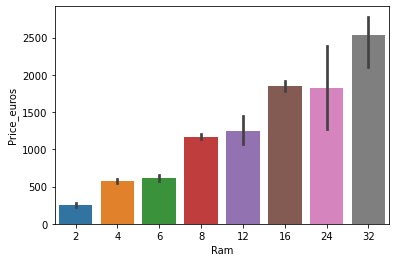

In [12]:
sns.barplot(x='Ram',y='Price_euros',data=df)  #so more ram = more price

<AxesSubplot:>

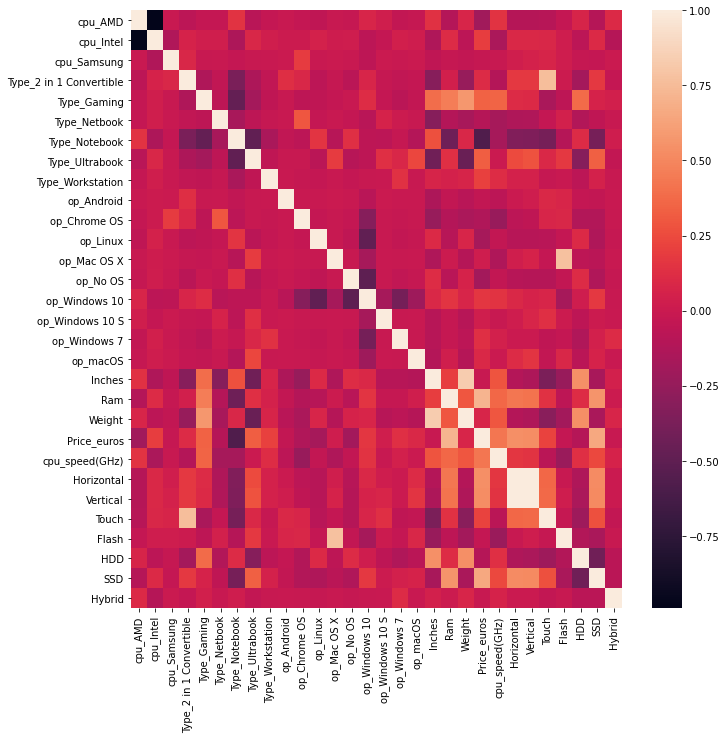

In [13]:
corrmat = df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

In [14]:
#using target encoding instead of one hot because gpu has toomany categorical values and the accuracy was better in case of target encoding
encoder=ce.TargetEncoder(cols='Gpu')
gpu_encoded = encoder.fit_transform(df['Gpu'],df['Price_euros'])
df['Gpu'] = gpu_encoded['Gpu']

In [15]:
#Lookup table to encode gpu of prediction data
temp1 = df['Gpu']
temp2 = data['Gpu']
gpudf = pd.DataFrame()
gpudf['Gpu']  = temp2
gpudf['val']  = temp1

In [16]:
df.head()

,cpu_AMD,cpu_Intel,cpu_Samsung,Type_2 in 1 Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,op_Android,...,Weight,Price_euros,cpu_speed(GHz),Horizontal,Vertical,Touch,Flash,HDD,SSD,Hybrid
1,0,1,0,0,0,0,0,1,0,0,...,1.37,1339.69,2.3,2560,1600,False,0,0.0,128,0.0
2,0,1,0,0,0,0,0,1,0,0,...,1.34,898.94,1.8,1440,900,False,128,0.0,0,0.0
3,0,1,0,0,0,0,1,0,0,0,...,1.86,575.00,2.5,1920,1080,False,0,0.0,256,0.0
4,0,1,0,0,0,0,0,1,0,0,...,1.83,2537.45,2.7,2880,1800,False,0,0.0,512,0.0
5,0,1,0,0,0,0,0,1,0,0,...,1.37,1803.60,3.1,2560,1600,False,0,0.0,256,0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 1 to 1320
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cpu_AMD                  1274 non-null   uint8  
 1   cpu_Intel                1274 non-null   uint8  
 2   cpu_Samsung              1274 non-null   uint8  
 3   Type_2 in 1 Convertible  1274 non-null   uint8  
 4   Type_Gaming              1274 non-null   uint8  
 5   Type_Netbook             1274 non-null   uint8  
 6   Type_Notebook            1274 non-null   uint8  
 7   Type_Ultrabook           1274 non-null   uint8  
 8   Type_Workstation         1274 non-null   uint8  
 9   op_Android               1274 non-null   uint8  
 10  op_Chrome OS             1274 non-null   uint8  
 11  op_Linux                 1274 non-null   uint8  
 12  op_Mac OS X              1274 non-null   uint8  
 13  op_No OS                 1274 non-null   uint8  
 14  op_Windows 10           

# model building

In [18]:
y = (df['Price_euros'])
X = np.array(df.drop(['Price_euros'],1))

In [19]:
X_train , X_test , y_train , y_test = model_selection.train_test_split(X , y , test_size = 0.2, random_state = 22)

# prediction data cleaning

In [23]:
pred_df = pd.DataFrame({'Company':['HP'],'Product':['250 G6'],'TypeName' : ['Notebook'],'Inches' : [14],'ScreenResolution' : ['IPS Panel Full HD 1920x1080'], 'Cpu' : ['Intel Core i7 7500U 2.7GHz'],'Ram' : ['8GB'],'Memory' : ['1TB SSD'],'Gpu' : ['Intel HD Graphics 620'], 'OpSys' : ['Linux'], 'Weight' : ['1.5kg']})
pred_df = clean(pred_df)

In [26]:
l = ['cpu_AMD','cpu_Intel','cpu_Samsung','Type_2 in 1 Convertible','Type_Gaming','Type_Netbook','Type_Notebook','Type_Ultrabook','Type_Workstation','op_Android','op_Chrome', 'op_Linux',
       'op_Mac OS X', 'op_No OS', 'op_Windows 10', 'op_Windows 10 S',
       'op_Windows 7', 'op_macOS']
for col in l:
    pred_df[col] = 0

In [27]:
pred_df.head()

,cpu_Intel,Type_Notebook,op_Linux,Inches,Ram,Gpu,Weight,cpu_speed(GHz),Horizontal,Vertical,...,Type_Ultrabook,Type_Workstation,op_Android,op_Chrome,op_Mac OS X,op_No OS,op_Windows 10,op_Windows 10 S,op_Windows 7,op_macOS
0,0,0,0,14,8,Intel HD Graphics 620,1.5,2.7,1920,1080,...,0,0,0,0,0,0,0,0,0,0


In [20]:
a = pred_df['Gpu'][0]
pred_df['Gpu'] = gpudf.loc[gpudf.Gpu==a,'val'].values[0]

# Linear regression

In [21]:
clf = LinearRegression ()
clf.fit(X_train , y_train)

LinearRegression()

In [22]:
clf.score(X_train,y_train)

0.7963795467974304

In [23]:
clf.score(X_test,y_test)

0.7888446110370675

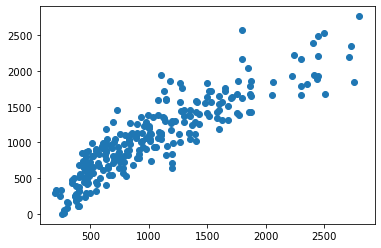

In [24]:
y_predicted = clf.predict(X_test)
plt.scatter(y_test,y_predicted)

# Ridge

In [25]:
ridlr = Ridge()
ridlr.fit(X_train, y_train)
score = ridlr.score(X_test,y_test)
score

0.789288850029188

# Random forest regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

In [27]:
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [28]:
rfr.score(X_train,y_train)  #train score

0.9754749335437228

In [29]:
rfr.score(X_test,y_test)   #test score

0.8536538271533083

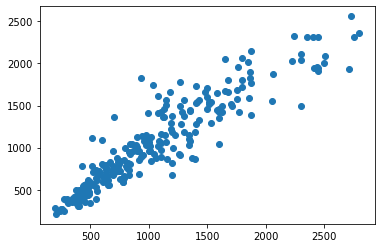

In [30]:
y_predicted = rfr.predict(X_test)
plt.scatter(y_test,y_predicted)

#### Random Forest regressor has best scores 

In [31]:
price = rfr.predict(pred_df)[0]
price

309.4830000000001